# Ticket Analysis & Enforcement Patterns
This notebook analyzes parking violation tickets to understand:
1. **Enforcement Patterns**: When/where enforcement is most active
2. **Capacity Indicators**: High ticket rates may indicate lots consistently at capacity
3. **Lot Comparison**: Compare ticket rates to AMP sessions and LPR detections
4. **Compliance Behavior**: Identify lots with chronic parking violations
**Note:** Tickets indicate non-payment violations, not necessarily full capacity. However, patterns can reveal:
- Desperation parking (people parking illegally when lot is full)
- High-demand periods
- Enforcement schedule patterns

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
pd.set_option('display.max_columns', None)
print("Libraries loaded successfully")

Libraries loaded successfully


## Load Ticket Data

In [ ]:
# Load raw ticket data
excel_file = pd.ExcelFile('../data/raw/Data_For_Class_Project.xlsx')
tickets = pd.read_excel(excel_file, sheet_name='Tickets')
print(f"Loaded {len(tickets):,} ticket records")
print(f"Date range: {tickets['Issue Date / Time'].min().date()} to {tickets['Issue Date / Time'].max().date()}")
print(f"\nColumns: {tickets.columns.tolist()}")
print(f"\nSample locations:")
print(tickets['Loc'].head(20))

Loaded 192,630 ticket records
Date range: 2018-07-02 to 2025-10-30

Columns: ['Issue Date / Time', 'Loc']

Sample locations:
0                   075 VETERANS MALL
1                   075 VETERANS MALL
2                     025 SCOTT-COMAN
3            079 S FAIRWAYTENNIS CRTS
4                  093 STEPHENSON N-W
5            110 MARTIN STADIUM NORTH
6              147 TENNIS COURTS WEST
7                       047 CHIEF JOE
8                       047 CHIEF JOE
9            031 OWEN SCIENCE LIBRARY
10                 039 WALLER-STIMSON
11                 052 THATUNA STREET
12             102 COLLEGE AT SPOKANE
13                 085 COLLEGE AVENUE
14                 032 FINE ARTS WEST
15             160 SOUTH FAIRWAY EAST
16                   009 BUSTAD NORTH
17                    104 WILSON ROAD
18                    104 WILSON ROAD
19    020 WILSON ROAD GREEN-1 PERMITS
Name: Loc, dtype: object


## Extract Lot Numbers from Location Strings

In [ ]:
def extract_lot_number(location):
    """
    Extract lot number from location string.
    Examples: '075 VETERANS MALL' -> '075'
              '025 SCOTT-COMAN' -> '025'
    """
    if pd.isna(location):
        return None
    # Look for 3-digit number at start of string
    match = re.match(r'^(\d{3})', str(location).strip())
    if match:
        return match.group(1)
    # Some locations might not have lot numbers
    return None
# Extract lot numbers
tickets['Lot_number'] = tickets['Loc'].apply(extract_lot_number)
# Statistics
with_lot = tickets['Lot_number'].notna().sum()
without_lot = tickets['Lot_number'].isna().sum()
print(f"Ticket location parsing:")
print(f"  With lot numbers: {with_lot:,} ({with_lot/len(tickets)*100:.1f}%)")
print(f"  Without lot numbers: {without_lot:,} ({without_lot/len(tickets)*100:.1f}%)")
print(f"\nUnique lot numbers: {tickets['Lot_number'].nunique()}")
print(f"\nTop 10 lots by ticket count:")
print(tickets['Lot_number'].value_counts().head(10))
# Show examples of locations without lot numbers
no_lot = tickets[tickets['Lot_number'].isna()]['Loc'].unique()
if len(no_lot) > 0:
    print(f"\nLocations without lot numbers ({len(no_lot)} unique):")
    print(no_lot[:20])

Ticket location parsing:
  With lot numbers: 188,425 (97.8%)
  Without lot numbers: 4,205 (2.2%)

Unique lot numbers: 187

Top 10 lots by ticket count:
Lot_number
071    25927
150    25072
146    10986
124     6547
020     6339
193     5518
114     3695
030     3669
025     3642
080     3578
Name: count, dtype: int64

Locations without lot numbers (127 unique):
[48 65 94 71 51 52 'HOG LANE' 28 30 85 32 'TEST' 9 76 83 20 46 25 3 2]


## Add Temporal Features

In [ ]:
# Rename for consistency
tickets = tickets.rename(columns={'Issue Date / Time': 'Issue_DateTime'})
tickets['Issue_DateTime'] = pd.to_datetime(tickets['Issue_DateTime'])
# Add temporal features
tickets['year'] = tickets['Issue_DateTime'].dt.year
tickets['month'] = tickets['Issue_DateTime'].dt.month
tickets['day'] = tickets['Issue_DateTime'].dt.day
tickets['hour'] = tickets['Issue_DateTime'].dt.hour
tickets['day_of_week'] = tickets['Issue_DateTime'].dt.dayofweek
tickets['day_name'] = tickets['Issue_DateTime'].dt.day_name()
tickets['is_weekend'] = tickets['day_of_week'].isin([5, 6]).astype(int)
# Add semester labels
def assign_semester(date):
    month = date.month
    year = date.year
    if month >= 8:
        return f"Fall {year}"
    elif month <= 5:
        return f"Spring {year}"
    else:
        return f"Summer {year}"
tickets['semester'] = tickets['Issue_DateTime'].apply(assign_semester)
print("Temporal features added successfully")
print(f"\nTickets by semester:")
print(tickets['semester'].value_counts().sort_index())

Temporal features added successfully

Tickets by semester:
semester
Fall 2018       8900
Fall 2019      12158
Fall 2020       6831
Fall 2021      14026
Fall 2022      14340
Fall 2023      16472
Fall 2024      15988
Fall 2025      12727
Spring 2019     9280
Spring 2020     7390
Spring 2021     6179
Spring 2022    11968
Spring 2023    14652
Spring 2024    13068
Spring 2025    15888
Summer 2018      711
Summer 2019     1848
Summer 2020      855
Summer 2021     1473
Summer 2022     1853
Summer 2023     1358
Summer 2024     2206
Summer 2025     2459
Name: count, dtype: int64


## Add Calendar Features

In [ ]:
# Load calendar data
games = pd.read_csv('../data/football_games.csv')
games['Date'] = pd.to_datetime(games['Date'])
calendar = pd.read_csv('../data/academic_calendar.csv')
calendar['Start_Date'] = pd.to_datetime(calendar['Start_Date'])
calendar['End_Date'] = pd.to_datetime(calendar['End_Date'])
print(f"Loaded {len(games)} game days and {len(calendar)} calendar events")
# Add game day indicator
game_dates = set(games['Date'].dt.date)
tickets['is_game_day'] = tickets['Issue_DateTime'].dt.date.isin(game_dates).astype(int)
# Add calendar event indicators
def check_if_in_period(date, calendar_df, event_type):
    events = calendar_df[calendar_df['Event_Type'] == event_type]
    for _, event in events.iterrows():
        if event['Start_Date'].date() <= date <= event['End_Date'].date():
            return 1
    return 0
tickets['ticket_date'] = tickets['Issue_DateTime'].dt.date
print("Adding calendar features...")
tickets['is_finals_week'] = tickets['ticket_date'].apply(
    lambda x: check_if_in_period(x, calendar, 'Finals_Week')
)
tickets['is_spring_break'] = tickets['ticket_date'].apply(
    lambda x: check_if_in_period(x, calendar, 'Spring_Break')
)
tickets['is_thanksgiving_break'] = tickets['ticket_date'].apply(
    lambda x: check_if_in_period(x, calendar, 'Thanksgiving_Break')
)
tickets['is_winter_break'] = tickets['ticket_date'].apply(
    lambda x: check_if_in_period(x, calendar, 'Winter_Break')
)
tickets['is_university_holiday'] = tickets['ticket_date'].apply(
    lambda x: check_if_in_period(x, calendar, 'University_Holiday')
)
tickets['is_any_break'] = (
    (tickets['is_spring_break'] == 1) |
    (tickets['is_thanksgiving_break'] == 1) |
    (tickets['is_winter_break'] == 1) |
    (tickets['is_university_holiday'] == 1)
).astype(int)
tickets.drop('ticket_date', axis=1, inplace=True)
print("\nCalendar features added successfully")
print(f"  Game day tickets: {tickets['is_game_day'].sum():,}")
print(f"  Finals week tickets: {tickets['is_finals_week'].sum():,}")
print(f"  Break period tickets: {tickets['is_any_break'].sum():,}")

Loaded 31 game days and 82 calendar events
Adding calendar features...

Calendar features added successfully
  Game day tickets: 4,331
  Finals week tickets: 4,405
  Break period tickets: 5,245


## Enforcement Pattern Analysis

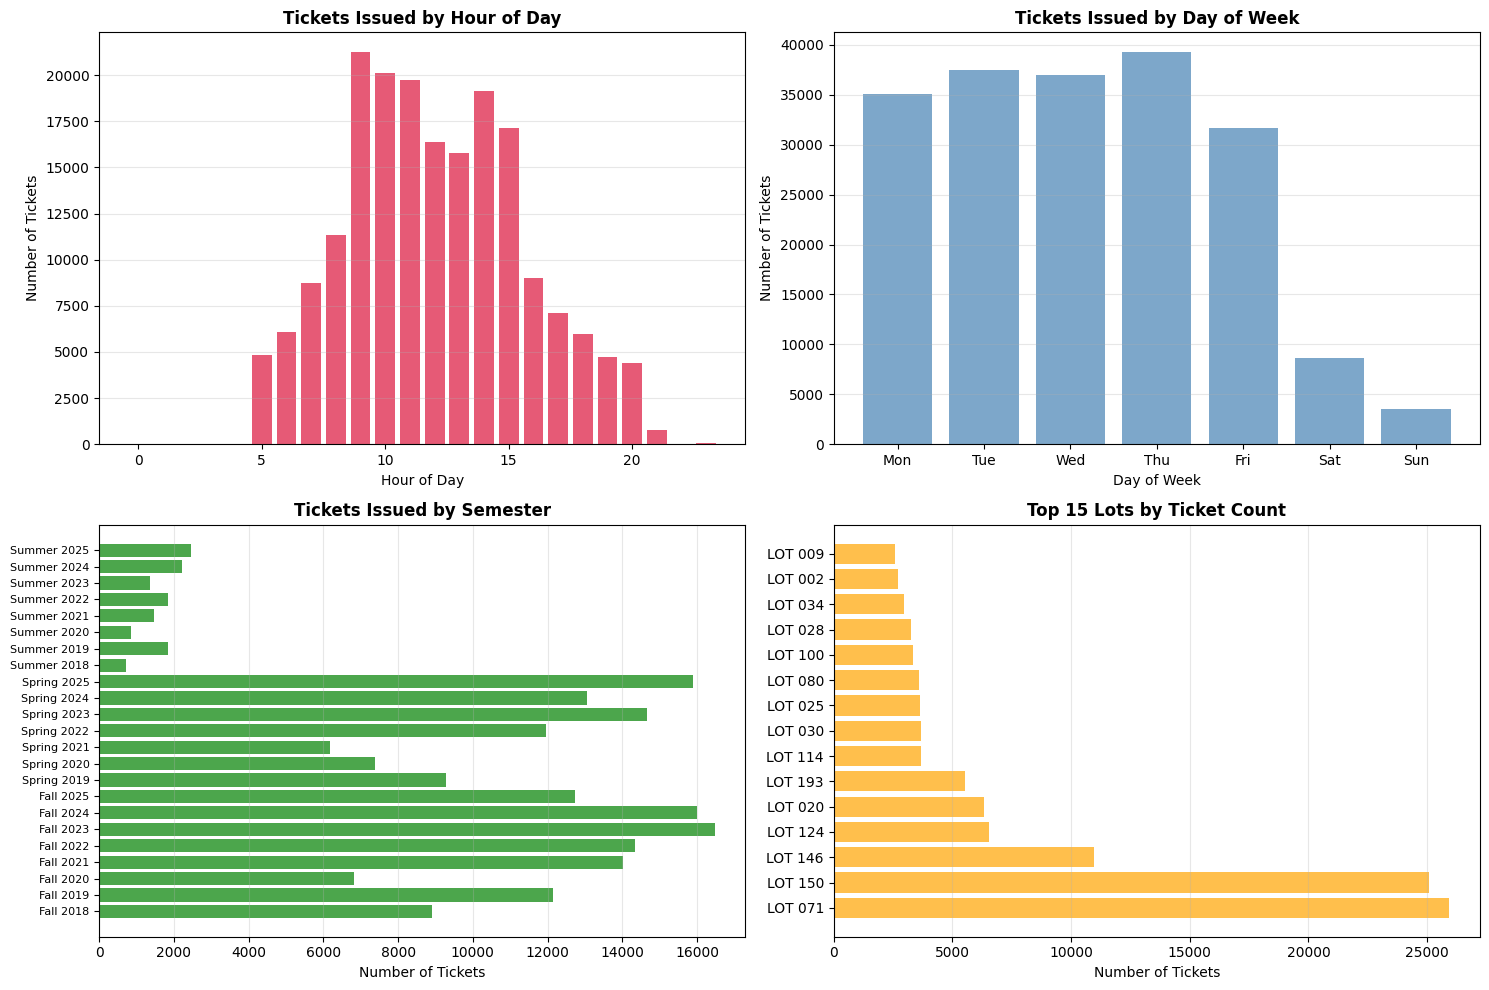

Enforcement pattern visualization saved


In [ ]:
# Analyze enforcement patterns by hour and day
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Tickets by hour of day
hourly = tickets.groupby('hour').size().reset_index(name='count')
axes[0, 0].bar(hourly['hour'], hourly['count'], color='crimson', alpha=0.7)
axes[0, 0].set_title('Tickets Issued by Hour of Day', fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Tickets')
axes[0, 0].grid(True, alpha=0.3, axis='y')
# Tickets by day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow = tickets.groupby('day_of_week').size().reset_index(name='count')
axes[0, 1].bar(range(7), dow['count'], color='steelblue', alpha=0.7)
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)
axes[0, 1].set_title('Tickets Issued by Day of Week', fontweight='bold')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Number of Tickets')
axes[0, 1].grid(True, alpha=0.3, axis='y')
# Tickets by semester
semester_counts = tickets['semester'].value_counts().sort_index()
axes[1, 0].barh(range(len(semester_counts)), semester_counts.values, color='green', alpha=0.7)
axes[1, 0].set_yticks(range(len(semester_counts)))
axes[1, 0].set_yticklabels(semester_counts.index, fontsize=8)
axes[1, 0].set_title('Tickets Issued by Semester', fontweight='bold')
axes[1, 0].set_xlabel('Number of Tickets')
axes[1, 0].grid(True, alpha=0.3, axis='x')
# Top 15 lots by ticket count
top_lots = tickets['Lot_number'].value_counts().head(15)
axes[1, 1].barh(range(len(top_lots)), top_lots.values, color='orange', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_lots)))
axes[1, 1].set_yticklabels([f"LOT {x}" for x in top_lots.index])
axes[1, 1].set_title('Top 15 Lots by Ticket Count', fontweight='bold')
axes[1, 1].set_xlabel('Number of Tickets')
axes[1, 1].grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../data/processed/ticket_enforcement_patterns.png', dpi=300, bbox_inches='tight')
plt.show()
print("Enforcement pattern visualization saved")

## Calendar Event Impact on Ticketing

In [ ]:
# Compare ticketing rates during different events
print("="*70)
print("TICKET RATES BY EVENT TYPE")
print("="*70)
total_tickets = len(tickets)
events = [
    ('Game Days', 'is_game_day'),
    ('Finals Weeks', 'is_finals_week'),
    ('Spring Break', 'is_spring_break'),
    ('Thanksgiving Break', 'is_thanksgiving_break'),
    ('Winter Break', 'is_winter_break'),
    ('University Holidays', 'is_university_holiday'),
    ('Any Break Period', 'is_any_break'),
    ('Weekends', 'is_weekend')
]
for event_name, col in events:
    count = tickets[col].sum()
    pct = count / total_tickets * 100
    print(f"{event_name:25} {count:>8,} tickets ({pct:>5.2f}%)")
# Calculate average tickets per day for each event type
print("\n" + "="*70)
print("AVERAGE TICKETS PER DAY")
print("="*70)
# Regular days (no special events)
regular_days = tickets[
    (tickets['is_game_day'] == 0) &
    (tickets['is_finals_week'] == 0) &
    (tickets['is_any_break'] == 0) &
    (tickets['is_weekend'] == 0)
]
regular_days_count = regular_days['Issue_DateTime'].dt.date.nunique()
if regular_days_count > 0:
    avg_regular = len(regular_days) / regular_days_count
    print(f"Regular weekdays: {avg_regular:.1f} tickets/day")
# Game days
game_day_tickets = tickets[tickets['is_game_day'] == 1]
game_day_count = game_day_tickets['Issue_DateTime'].dt.date.nunique()
if game_day_count > 0:
    avg_game = len(game_day_tickets) / game_day_count
    print(f"Game days: {avg_game:.1f} tickets/day ({avg_game/avg_regular:.1f}x normal)")
# Finals weeks
finals_tickets = tickets[tickets['is_finals_week'] == 1]
finals_days = finals_tickets['Issue_DateTime'].dt.date.nunique()
if finals_days > 0:
    avg_finals = len(finals_tickets) / finals_days
    print(f"Finals weeks: {avg_finals:.1f} tickets/day ({avg_finals/avg_regular:.1f}x normal)")

TICKET RATES BY EVENT TYPE
Game Days                    4,331 tickets ( 2.25%)
Finals Weeks                 4,405 tickets ( 2.29%)
Spring Break                 1,466 tickets ( 0.76%)
Thanksgiving Break           1,015 tickets ( 0.53%)
Winter Break                 1,886 tickets ( 0.98%)
University Holidays            878 tickets ( 0.46%)
Any Break Period             5,245 tickets ( 2.72%)
Weekends                    12,189 tickets ( 6.33%)

AVERAGE TICKETS PER DAY
Regular weekdays: 107.2 tickets/day
Game days: 139.7 tickets/day (1.3x normal)
Finals weeks: 88.1 tickets/day (0.8x normal)


## Lot-Level Ticket Analysis

In [ ]:
# Calculate ticket statistics per lot
lot_stats = tickets.groupby('Lot_number').agg({
    'Issue_DateTime': ['count', 'min', 'max'],
    'is_game_day': 'sum',
    'is_finals_week': 'sum',
    'is_weekend': 'sum'
}).reset_index()
lot_stats.columns = ['Lot_number', 'total_tickets', 'first_ticket', 'last_ticket',
                     'game_day_tickets', 'finals_tickets', 'weekend_tickets']
lot_stats = lot_stats.sort_values('total_tickets', ascending=False)
print("Top 20 lots by total tickets:")
print(lot_stats.head(20).to_string(index=False))
# Calculate tickets per hour for top lots
print("\n" + "="*70)
print("HOURLY TICKET DISTRIBUTION - TOP 5 LOTS")
print("="*70)
top_5_lots = lot_stats.head(5)['Lot_number'].tolist()
for lot in top_5_lots:
    lot_tickets = tickets[tickets['Lot_number'] == lot]
    hourly_dist = lot_tickets.groupby('hour').size()
    peak_hour = hourly_dist.idxmax()
    peak_count = hourly_dist.max()
    print(f"\nLOT {lot}: {len(lot_tickets):,} total tickets")
    print(f"  Peak enforcement: {peak_hour}:00 ({peak_count} tickets)")
    print(f"  Hourly distribution: {hourly_dist.to_dict()}")

Top 20 lots by total tickets:
Lot_number  total_tickets        first_ticket         last_ticket  game_day_tickets  finals_tickets  weekend_tickets
       071          25927 2018-07-05 17:05:00 2025-10-30 15:32:00               129             746              887
       150          25072 2018-07-09 17:15:00 2025-10-30 13:50:00                43             692              336
       146          10986 2018-07-06 11:59:00 2025-10-30 14:46:00               118             165              101
       124           6547 2018-07-19 13:14:00 2025-10-30 09:30:00               308             137              380
       020           6339 2018-07-02 13:21:00 2025-10-30 10:49:00                10             227               20
       193           5518 2022-05-11 09:10:00 2025-10-30 15:17:00                66             239               53
       114           3695 2018-07-02 13:48:00 2025-10-30 15:02:00                39              72              344
       030           3669 2018-07-

## Map Tickets to Zones (Using Lot Mapping)

In [ ]:
# Load lot mapping
lot_mapping = pd.read_csv('../data/lot_mapping_enhanced.csv')
lot_mapping['Lot_number'] = lot_mapping['Lot_number'].astype(str).str.strip()
# Merge tickets with lot mapping
tickets_mapped = tickets.merge(
    lot_mapping[['Lot_number', 'Zone_Name', 'zone_type']], 
    on='Lot_number', 
    how='left'
)
# Check mapping coverage
mapped = tickets_mapped['Zone_Name'].notna().sum()
unmapped = tickets_mapped['Zone_Name'].isna().sum()
print(f"Ticket-to-Zone Mapping Coverage:")
print(f"  Mapped: {mapped:,} tickets ({mapped/len(tickets_mapped)*100:.1f}%)")
print(f"  Unmapped: {unmapped:,} tickets ({unmapped/len(tickets_mapped)*100:.1f}%)")
# Show ticket counts by zone
if mapped > 0:
    print(f"\nTickets by Zone (mapped lots only):")
    zone_tickets = tickets_mapped[tickets_mapped['Zone_Name'].notna()].groupby('Zone_Name').size().sort_values(ascending=False)
    print(zone_tickets.head(15))
else:
    print("\nNo tickets mapped to zones yet. Update lot_mapping.csv and re-run.")

Ticket-to-Zone Mapping Coverage:
  Mapped: 91,201 tickets (47.3%)
  Unmapped: 101,508 tickets (52.7%)

Tickets by Zone (mapped lots only):
Zone_Name
Paid          41734
Green 5       10466
Green 3        6540
Apartments     4789
Yellow 4       4332
Green 4        3923
Green 1        2560
Crimson 2      2482
Red 4          2262
Orange 4       1824
Yellow 1       1724
Grey 2         1489
Yellow 2       1359
Red 1          1176
Gray 1         1042
dtype: int64


## Save Processed Ticket Data

In [ ]:
# Save enriched ticket data
tickets_mapped.to_csv('../data/processed/tickets_enriched.csv', index=False)
# Save lot-level ticket statistics
lot_stats.to_csv('../data/processed/lot_ticket_stats.csv', index=False)
print("Ticket data saved:")
print(f"  tickets_enriched.csv: {len(tickets_mapped):,} tickets with calendar features")
print(f"  lot_ticket_stats.csv: {len(lot_stats)} lots with ticket statistics")

Ticket data saved:
  tickets_enriched.csv: 192,709 tickets with calendar features
  lot_ticket_stats.csv: 187 lots with ticket statistics

TICKET ANALYSIS COMPLETE

Processed 192,630 parking tickets from 2018-07-02 to 2025-10-30

Key Findings:
  - Extracted lot numbers from 188,425 ticket locations
  - Identified 187 unique lots with violations
  - Mapped 91,201 tickets to zones (47.3% coverage)
